# **Challenge 1: Cardiovascular disease diagnosis using cardiac magnetic resonance radiomics and machine learning**

In this project, we aim to leverage machine learning to automatically classify patients'
examinations into five distinct classes using as predictors cardiac magnetic resonance
radiomics features.

## **0. Uploading and Understanding the Dataset**

In [ ]:
# Maria Fité
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Q2 - MEDAS/ML/Challange 1/ACDC_radiomics.csv')

Mounted at /content/drive


In [ ]:
# Claudia Lozano
import pandas as pd
df = pd.read_csv('ACDC_radiomics.csv')

In [ ]:
print(df.head())

   original_shape_Elongation_LV_ED  original_shape_Flatness_LV_ED  \
0                         0.560917                       0.110560   
1                         0.454960                       0.088323   
2                         0.541682                       0.105418   
3                         0.487949                       0.105906   
4                         0.442150                       0.095225   

   original_shape_LeastAxisLength_LV_ED  original_shape_MajorAxisLength_LV_ED  \
0                              6.592758                             59.630582   
1                              5.730218                             64.877933   
2                              6.711577                             63.666027   
3                              6.726159                             63.510529   
4                              7.186765                             75.471150   

   original_shape_Maximum2DDiameterColumn_LV_ED  \
0                                     45.398238

In [ ]:
df.shape

(100, 645)

In [ ]:
import re

def parse_column(col):
    if col.startswith("original_"):
        parts = col.split("_")
        return {
            "full_name": col,
            "category": parts[1],         # shape, firstorder, glcm, etc.
            "feature": parts[2],          # Strength, Mean, etc.
            "structure": parts[3],        # MYO, LV, RV
            "phase": parts[4]             # ED, ES
        }
    else:
        return None

parsed = [parse_column(col) for col in df.columns if col.startswith("original_")]
parsed = [p for p in parsed if p]  # elimina Nones

# convertir a df
meta_df = pd.DataFrame(parsed)

In [ ]:
meta_df

,full_name,category,feature,structure,phase
0,original_shape_Elongation_LV_ED,shape,Elongation,LV,ED
1,original_shape_Flatness_LV_ED,shape,Flatness,LV,ED
2,original_shape_LeastAxisLength_LV_ED,shape,LeastAxisLength,LV,ED
3,original_shape_MajorAxisLength_LV_ED,shape,MajorAxisLength,LV,ED
4,original_shape_Maximum2DDiameterColumn_LV_ED,shape,Maximum2DDiameterColumn,LV,ED
...,...,...,...,...,...
637,original_ngtdm_Busyness_MYO_ES,ngtdm,Busyness,MYO,ES
638,original_ngtdm_Coarseness_MYO_ES,ngtdm,Coarseness,MYO,ES
639,original_ngtdm_Complexity_MYO_ES,ngtdm,Complexity,MYO,ES
640,original_ngtdm_Contrast_MYO_ES,ngtdm,Contrast,MYO,ES


In [ ]:
meta_df.describe()

,full_name,category,feature,structure,phase
count,642,642,642,642,642
unique,642,7,101,3,2
top,original_ngtdm_Strength_MYO_ES,glcm,GrayLevelVariance,LV,ED
freq,1,144,18,214,321


In [ ]:
meta_df.feature.unique()

array(['Elongation', 'Flatness', 'LeastAxisLength', 'MajorAxisLength',
       'Maximum2DDiameterColumn', 'Maximum2DDiameterRow',
       'Maximum2DDiameterSlice', 'Maximum3DDiameter', 'MeshVolume',
       'MinorAxisLength', 'Sphericity', 'SurfaceArea',
       'SurfaceVolumeRatio', 'VoxelVolume', '10Percentile',
       '90Percentile', 'Energy', 'Entropy', 'InterquartileRange',
       'Kurtosis', 'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median',
       'Minimum', 'Range', 'RobustMeanAbsoluteDeviation',
       'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Uniformity',
       'Variance', 'Autocorrelation', 'ClusterProminence', 'ClusterShade',
       'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage',
       'DifferenceEntropy', 'DifferenceVariance', 'Id', 'Idm', 'Idmn',
       'Idn', 'Imc1', 'Imc2', 'InverseVariance', 'JointAverage',
       'JointEnergy', 'JointEntropy', 'MCC', 'MaximumProbability',
       'SumAverage', 'SumEntropy', 'SumSquares', 'DependenceEntropy',
  

In [ ]:
meta_df.structure.unique()

array(['LV', 'RV', 'MYO'], dtype=object)

In [ ]:
meta_df.category.unique()

array(['shape', 'firstorder', 'glcm', 'gldm', 'glrlm', 'glszm', 'ngtdm'],
      dtype=object)

In [ ]:
meta_df.phase.unique()

array(['ED', 'ES'], dtype=object)

## **1. Exploratory Data Analysis**

This step is crutial to be done before starting any modelling as it helps us to understand our data and figure out important factors that could influence the model development.

### **1.1. Summary statistics and missing values**

In [ ]:
df.dtypes

,0
original_shape_Elongation_LV_ED,float64
original_shape_Flatness_LV_ED,float64
original_shape_LeastAxisLength_LV_ED,float64
original_shape_MajorAxisLength_LV_ED,float64
original_shape_Maximum2DDiameterColumn_LV_ED,float64
...,...
original_ngtdm_Contrast_MYO_ES,float64
original_ngtdm_Strength_MYO_ES,float64
height,int64
weight,int64


In [ ]:
df.describe()

,original_shape_Elongation_LV_ED,original_shape_Flatness_LV_ED,original_shape_LeastAxisLength_LV_ED,original_shape_MajorAxisLength_LV_ED,original_shape_Maximum2DDiameterColumn_LV_ED,original_shape_Maximum2DDiameterRow_LV_ED,original_shape_Maximum2DDiameterSlice_LV_ED,original_shape_Maximum3DDiameter_LV_ED,original_shape_MeshVolume_LV_ED,original_shape_MinorAxisLength_LV_ED,...,original_glszm_ZoneEntropy_MYO_ES,original_glszm_ZonePercentage_MYO_ES,original_glszm_ZoneVariance_MYO_ES,original_ngtdm_Busyness_MYO_ES,original_ngtdm_Coarseness_MYO_ES,original_ngtdm_Complexity_MYO_ES,original_ngtdm_Contrast_MYO_ES,original_ngtdm_Strength_MYO_ES,height,weight
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.559329,0.116327,7.027303,61.907922,48.331549,67.959597,62.818826,69.083915,7830.536250,34.273933,...,4.278958,0.030509,2.157801e+05,43.418370,0.001517,22.200001,0.012399,0.055277,170.840000,74.960000
std,0.086312,0.044954,2.421983,11.241951,11.736217,12.777552,14.225637,12.871657,4335.369673,6.211781,...,0.657176,0.030895,4.108047e+05,35.480593,0.000714,61.319519,0.009736,0.081740,9.710683,16.632037
min,0.374291,0.046936,3.365035,41.204891,21.095023,46.043458,30.066593,47.053161,1984.375000,21.095961,...,3.193796,0.003233,3.176649e+02,1.770204,0.000443,0.562589,0.001240,0.003402,140.000000,35.000000
25%,0.496768,0.090354,5.547015,55.335903,41.403462,60.588288,54.071708,61.554810,5201.843750,30.218074,...,3.814769,0.014291,5.873236e+04,19.791961,0.001002,2.485099,0.007079,0.012007,165.000000,62.750000
50%,0.562325,0.105700,6.572642,61.729255,45.951022,66.471721,61.683455,67.646128,6743.020833,33.479543,...,4.150802,0.021955,1.295591e+05,34.946317,0.001372,4.207814,0.009971,0.022363,171.500000,75.000000
75%,0.603154,0.123933,7.438589,66.349397,53.235327,73.659458,70.000000,74.787973,9282.125000,38.097940,...,4.638770,0.031424,2.345962e+05,55.753123,0.001819,13.739332,0.013831,0.062622,178.000000,85.000000
max,0.791923,0.286265,16.244584,131.551946,90.138782,143.391074,139.003597,144.371050,26335.375000,59.645360,...,6.251883,0.205567,3.806504e+06,185.157865,0.004126,515.368502,0.066583,0.450330,192.000000,123.000000


In [ ]:
df.isnull().sum()

,0
original_shape_Elongation_LV_ED,0
original_shape_Flatness_LV_ED,0
original_shape_LeastAxisLength_LV_ED,0
original_shape_MajorAxisLength_LV_ED,0
original_shape_Maximum2DDiameterColumn_LV_ED,0
...,...
original_ngtdm_Contrast_MYO_ES,0
original_ngtdm_Strength_MYO_ES,0
height,0
weight,0


### **1.2. Correlations**

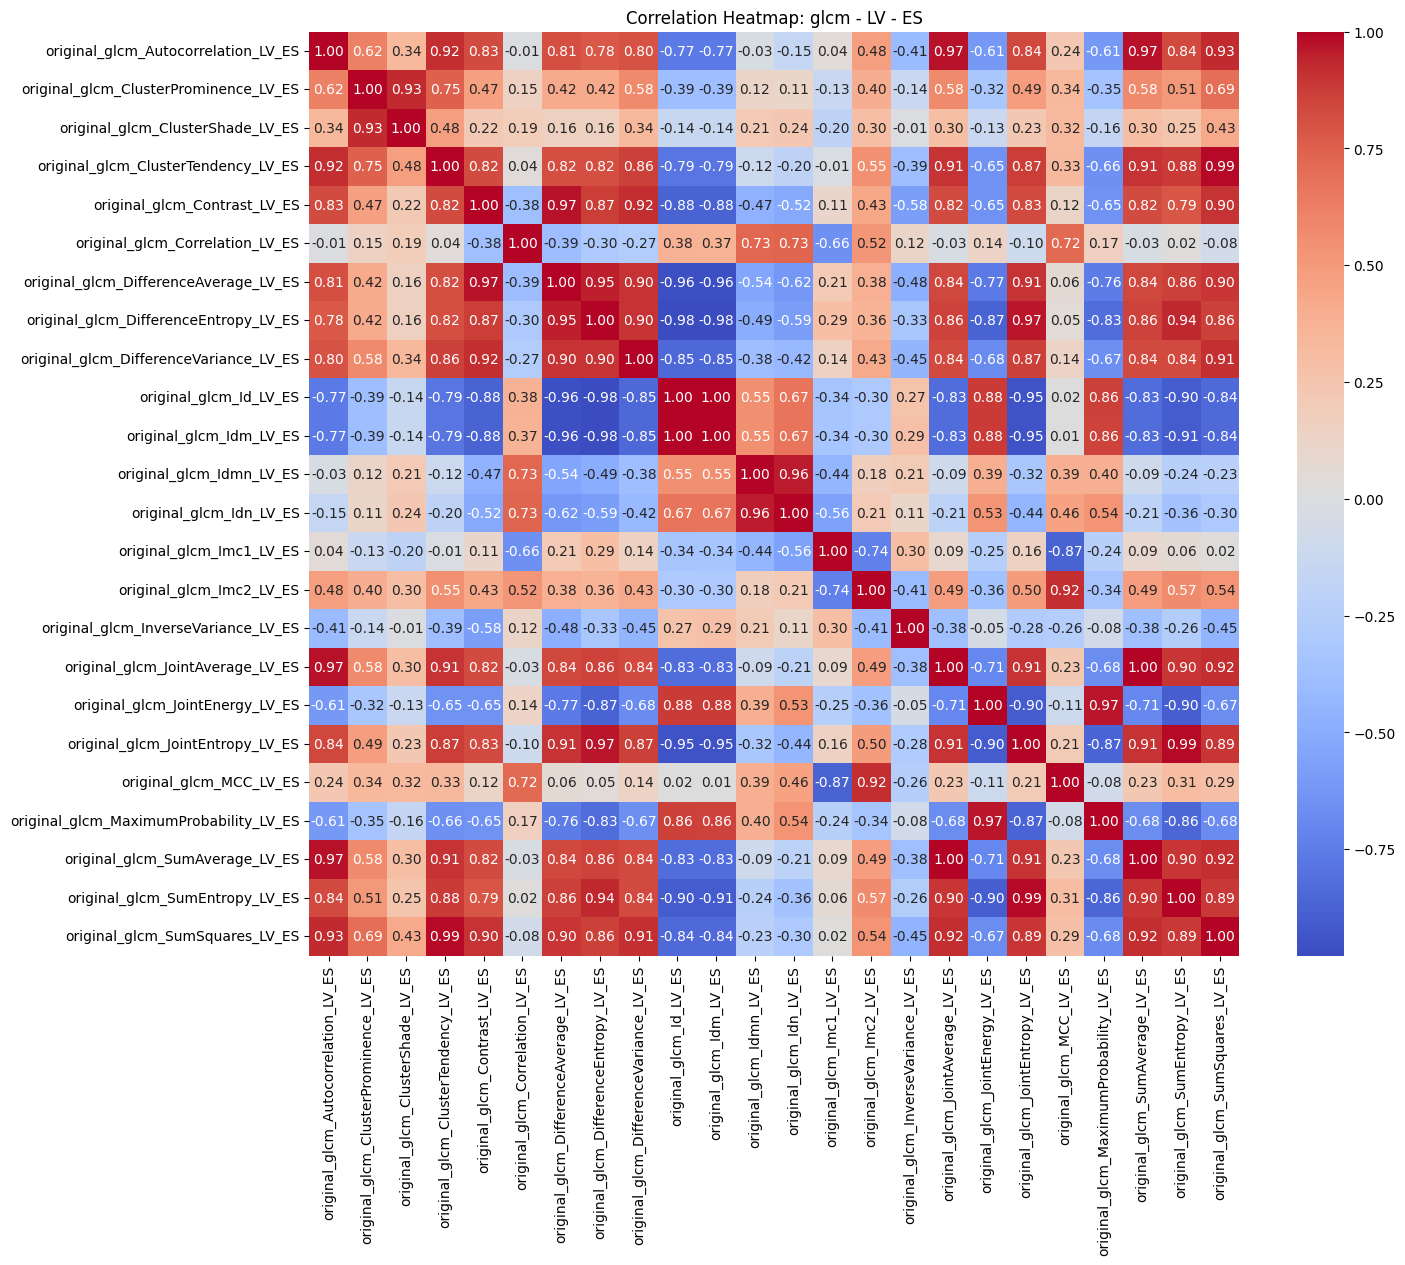

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the category, structure, and phase you are interested in
category = 'glcm'  # Example category
structure = 'LV'   # Example structure
phase = 'ES'       # Example phase

# Filter the features by the specified category, structure, and phase
filtered_features = meta_df[
    (meta_df['category'] == category) &
    (meta_df['structure'] == structure) &
    (meta_df['phase'] == phase)
]['full_name']

# Extract the corresponding data from the original DataFrame
filtered_data = df[filtered_features]

# Calculate the correlation matrix
corr_matrix = filtered_data.corr()

# Plot the heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title(f'Correlation Heatmap: {category} - {structure} - {phase}')
plt.show()

In [ ]:
import pandas as pd
import numpy as np

def high_corr_groups(corr_matrix, threshold=0.9):
    corr_matrix = corr_matrix.abs().copy()
    np.fill_diagonal(corr_matrix.values, 0)

    visited = set()
    features = corr_matrix.columns.tolist()
    groups = []

    def dfs(feature, group):
        for neighbor in corr_matrix.columns:
            if neighbor not in visited and corr_matrix.at[feature, neighbor] > threshold:
                visited.add(neighbor)
                group.append(neighbor)
                dfs(neighbor, group)

    for feature in features:
        if feature not in visited:
            visited.add(feature)
            group = [feature]
            dfs(feature, group)
            groups.append(group)

    return groups



In [ ]:
feature_groups = high_corr_groups(corr_matrix)
print(len(feature_groups))
feature_groups

7


[['original_glcm_Autocorrelation_LV_ES',
  'original_glcm_ClusterTendency_LV_ES',
  'original_glcm_Contrast_LV_ES',
  'original_glcm_DifferenceAverage_LV_ES',
  'original_glcm_DifferenceEntropy_LV_ES',
  'original_glcm_DifferenceVariance_LV_ES',
  'original_glcm_Id_LV_ES',
  'original_glcm_Idm_LV_ES',
  'original_glcm_JointAverage_LV_ES',
  'original_glcm_JointEnergy_LV_ES',
  'original_glcm_JointEntropy_LV_ES',
  'original_glcm_MaximumProbability_LV_ES',
  'original_glcm_SumAverage_LV_ES',
  'original_glcm_SumEntropy_LV_ES',
  'original_glcm_SumSquares_LV_ES'],
 ['original_glcm_ClusterProminence_LV_ES', 'original_glcm_ClusterShade_LV_ES'],
 ['original_glcm_Correlation_LV_ES'],
 ['original_glcm_Idmn_LV_ES', 'original_glcm_Idn_LV_ES'],
 ['original_glcm_Imc1_LV_ES'],
 ['original_glcm_Imc2_LV_ES', 'original_glcm_MCC_LV_ES'],
 ['original_glcm_InverseVariance_LV_ES']]

In [ ]:
representative_features = [group[0] for group in feature_groups]
representative_features

['original_glcm_Autocorrelation_LV_ES',
 'original_glcm_ClusterProminence_LV_ES',
 'original_glcm_Correlation_LV_ES',
 'original_glcm_Idmn_LV_ES',
 'original_glcm_Imc1_LV_ES',
 'original_glcm_Imc2_LV_ES',
 'original_glcm_InverseVariance_LV_ES']

### **1.3. ML Analysis Tools**


LDA → For seeing if your features meaningfully separate classes.

PCA → For understanding feature variance and structure.

t-SNE → For visualizing local clusters or relationships.

k-means → For evaluating natural groupings and testing alignment with labels.



**Best choices when you have labels**


**LDA** is the most informative for class-based EDA:

- Directly optimizes separation between your classes.

- Helps identify the most discriminative features.

- Great for visualizing how well your features distinguish the classes.


**PCA** is still useful even with labels:

- Shows which features explain most variance, regardless of class.

- May reveal hidden patterns, such as imaging phase or structure effects.

- You can color the PCA plot by class to see overlap or separation.


**t-SNE** is helpful but should be used carefully:

- It's unsupervised and nonlinear, so it may find structure not related to the class.

- But it's great for visualizing potential subgroups and exploring if classes form separate "clouds".

- Just don’t use it for downstream modeling — only for insight.


**k-means** is best for:

- Testing whether unsupervised groups correspond to classes.

- Discovering subtypes or structure not reflected in the label.

- You can then do things like:
pd.crosstab(df['Cluster'], df['Label'])
to see alignment between clusters and true classes.

In this section, we are going to use different ML tools to visualize patterns in our data, ML tools are specially usefull when having high-dimensionallity data (which is our case). But, before using any ML thecnique, it is essential to scale our data. This is a crutial step as features are in very different ranges of values. If we didn't do that features with larger values could dominate the analysis, even if they weren’t more informative than the other ones.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop(columns=['class'])  # Features
y = df['class']  # Target

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

The first ML tool that we will apply is the **Liniar Discriminant Analysis (LDA)**, this will allow to optimize the separation of our classes, see how well the classes are separated and see the most important features when separating the classes.

The number of components is:  4
For component 1:
original_shape_MeshVolume_RV_ES                           4.899654
original_shape_VoxelVolume_RV_ES                          4.885090
original_gldm_GrayLevelNonUniformity_RV_ES                4.786138
original_shape_Maximum2DDiameterSlice_RV_ES               3.747847
original_firstorder_Kurtosis_LV_ES                        3.084156
original_glcm_Correlation_MYO_ES                          3.080766
original_glrlm_GrayLevelNonUniformity_RV_ES               2.938208
original_shape_Maximum2DDiameterRow_RV_ES                 2.911044
original_glszm_GrayLevelNonUniformityNormalized_MYO_ES    2.909973
original_gldm_DependenceNonUniformityNormalized_MYO_ES    2.772650
dtype: float64


For component 2:
original_shape_Maximum2DDiameterSlice_RV_ES               2.625060
original_shape_MeshVolume_RV_ES                           2.621418
original_shape_VoxelVolume_RV_ES                          2.617609
original_shape_MinorAxisLength_RV_ES          

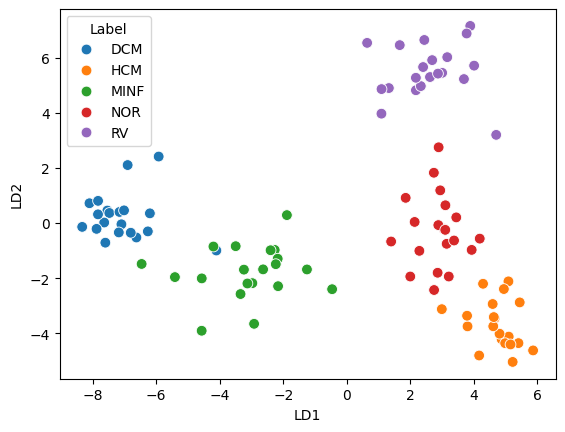

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import seaborn as sns

# Optimize separation between classes
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_scaled, y)

# Goodness of class separation
n_components = X_lda.shape[1]
print("The number of components is: ", n_components)
lda_cols = [f"LD{i+1}" for i in range(n_components)]
df_lda = pd.DataFrame(X_lda, columns=lda_cols)
df_lda["Label"] = y
sns.scatterplot(data=df_lda, x="LD1", y="LD2", hue="Label", palette="tab10", s=60)

# Most important features
lda_coefs = pd.Series(lda.coef_[0], index=X.columns)
print("For component 1:")
print(lda_coefs.abs().sort_values(ascending=False).head(10))
lda_coefs = pd.Series(lda.coef_[1], index=X.columns)
print("\n")
print("For component 2:")
print(lda_coefs.abs().sort_values(ascending=False).head(10))
lda_coefs = pd.Series(lda.coef_[2], index=X.columns)
print("\n")
print("For component 3:")
print(lda_coefs.abs().sort_values(ascending=False).head(10))
lda_coefs = pd.Series(lda.coef_[3], index=X.columns)
print("\n")
print("For component 4:")
print(lda_coefs.abs().sort_values(ascending=False).head(10))

From the plot, it can be seen that the components 1 and 2 are quite good at discriminating classes, considering that there are four components, we can ensure that the classes can be well separated. Regarding to the most important features, we can see printed the top ten most important features of each component. Having a quick overview we can see that those features are associated with the phase end of systole (ES) and the most relevant structures are right ventricle (RV) and myocardium (MYO).

Now, it is time to use the **Principal Component Analysis (PCA)**, this will allow us to see which features explain most of the variance. As it is an unsupervised thecnique, we have to consider that it will not help us to find which features can mostly separate class, it just will explain the variance.

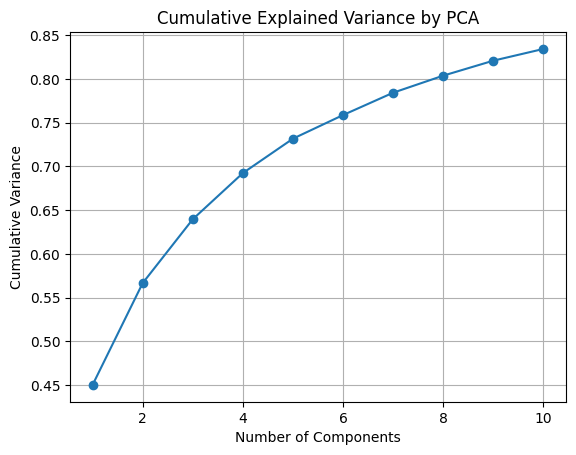


For principal component 1:
original_firstorder_90Percentile_RV_ED 	 0.0575
original_firstorder_90Percentile_RV_ES 	 0.0572
original_firstorder_RootMeanSquared_RV_ED 	 0.0570
original_firstorder_90Percentile_LV_ED 	 0.0569
original_glcm_JointAverage_LV_ED 	 0.0568
original_glcm_SumAverage_LV_ED 	 0.0568
original_firstorder_Mean_RV_ED 	 0.0567
original_firstorder_Maximum_RV_ES 	 0.0567
original_firstorder_Maximum_RV_ED 	 0.0567
original_firstorder_RootMeanSquared_RV_ES 	 0.0565

For principal component 2:
original_shape_SurfaceArea_MYO_ES 	 0.1057
original_shape_SurfaceArea_MYO_ED 	 0.1055
original_shape_Maximum2DDiameterColumn_MYO_ED 	 0.1042
original_shape_Maximum3DDiameter_MYO_ED 	 0.1036
original_shape_Maximum2DDiameterRow_MYO_ED 	 0.1032
original_shape_Maximum3DDiameter_MYO_ES 	 0.1029
original_shape_MajorAxisLength_MYO_ED 	 0.1029
original_shape_MinorAxisLength_MYO_ED 	 0.1027
original_shape_Maximum2DDiameterColumn_MYO_ES 	 0.1024
original_shape_Maximum2DDiameterRow_MYO_ES 	 0.102

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Explained variance
plt.figure()
plt.plot(range(1, 11), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title("Cumulative Explained Variance by PCA")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.show()

# Show the component contribution
loadings = pca.components_
feature_names = X.columns
n_components_to_display = 10
top_n = 10

for i in range(n_components_to_display):
    component_loadings = loadings[i]
    abs_loadings = np.abs(component_loadings)
    top_indices = abs_loadings.argsort()[::-1][:top_n]

    print(f"\nFor principal component {i+1}:")
    for idx in top_indices:
        print(f"{feature_names[idx]} \t {component_loadings[idx]:.4f}")

From this plot we can see that for 10 components the explained variance is almost of 85%, considering that the number of features is 644, this means that most of the features are correlated and so their contibution of information is redundant. It is important to highlight that we observed that PC1 was driven by first-order intensity statistics related to the RV and LV at ED and ES phases. PC2 captured geometric variations in the myocardium and PCs 3–10 were characterized by texture-based features across all anatomical structures. The separation of feature types across principal components highlights that different sources of variation (shape, intensity, texture) are present.

Now, it is time to use **t-SNE**, that will allow us to visualize the high dimensional data in 2D and identify local structures (small clusters, subgroups).

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


<Axes: xlabel='Dim1', ylabel='Dim2'>

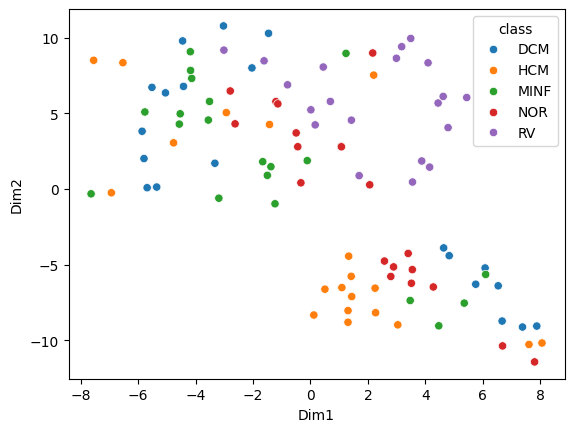

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=20, n_iter=5000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

df_tsne = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])
df_tsne["class"] = y
sns.scatterplot(data=df_tsne, x="Dim1", y="Dim2", hue="class")

The results found two different clusters. In the first one it seems that the algorithm is capable of separating classes MINF (except some outliars) and RV from the others but not distinguishing among them with this set of features. Regarding to the second clauster, seems to be slightly good at identifying HCM from the rest of the classes but with some problems. This suggests us that for discriminating the different classes some feature selection and engeneering should be done.

Finally, we will perform a **k-means** claustering in order to see how well the different classes can be separated using all the features we have.

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Compare to actual labels
ct = pd.crosstab(clusters, df["class"])
print(ct)

class  DCM  HCM  MINF  NOR  RV
row_0                         
0        0    1     1    0   0
1        5   11     5    8   3
2       12    6    14   10  17
3        0    0     0    1   0
4        3    2     0    1   0


Clausters 0, 3 and 4 have very few elements, which will be not relevant for our analysis. Regarding to clauster 2 it seems that the algorithm is capable of separating classes DCM, MINF and RV from the others but not distinguishing among them with this set of features. Clauster 1 seems to be slightly good at identifying HCM from the rest of the classes but with some problems. This suggests us that for discriminating the different classes some feature selection and engeneering should be done.

It is important to highlight that results in the k-means are similar to the ones obtained in the t-SNE, wich makes the results consistant. What we can ensure is that from our dataset, HCM is very different from MINF and RV, the other classes are not that different from the rest. In order to distinguish between all of them, some feature engeneering and reduction should be done.

### **1.4. Plotting Variables of Interest**

This section aims to do some visual representation of the dataset.

First of all, we will see the class distribution in a bar plot. It can be seen that the nomber of classes is balanced in the dataset.

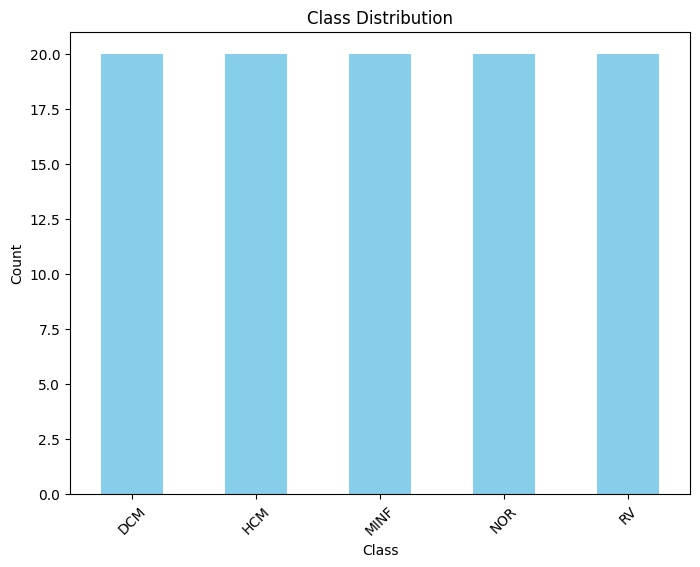

In [ ]:
# Adistributions of class
class_counts = df['class'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Now, we will plot the distribution of height and weight. As it can be seen they are normally distriibuted.

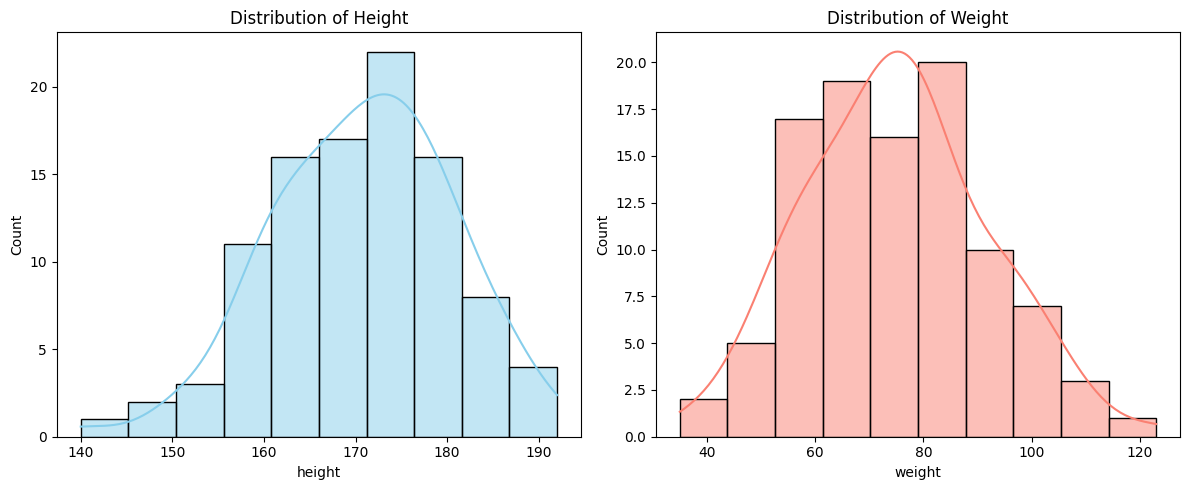

In [ ]:
# distributions of height and weight
fig1, axes1 = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['height'], kde=True, ax=axes1[0], color='skyblue')
axes1[0].set_title('Distribution of Height')
sns.histplot(df['weight'], kde=True, ax=axes1[1], color='salmon')
axes1[1].set_title('Distribution of Weight')
plt.tight_layout()
plt.show()

Moreover, we will see the distribution of those variables by class. It can be seen that there are not huge differences in height, but there are slightly ones in weight.

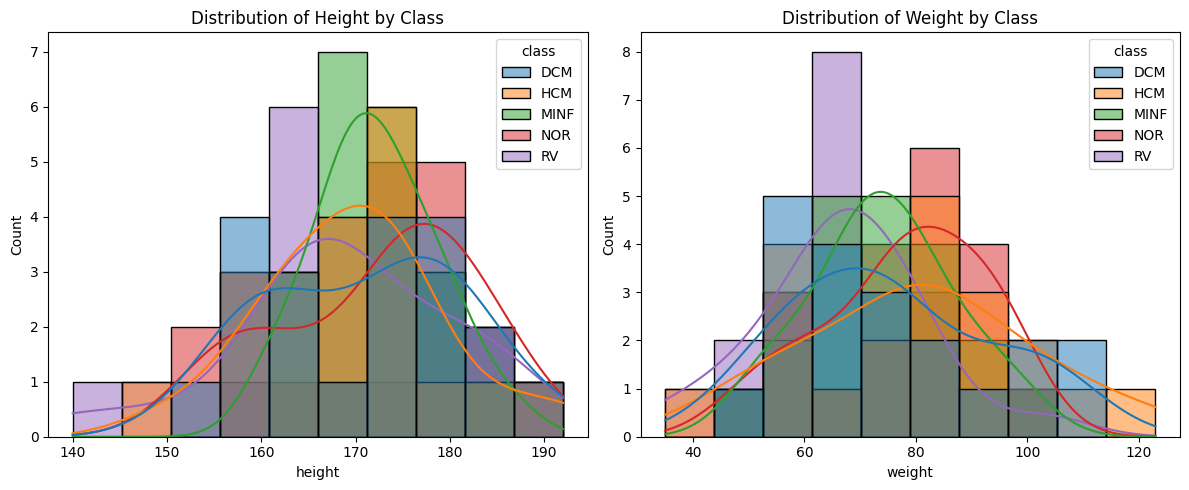

In [ ]:
# distributions of height and weight by class
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=df, x='height', hue='class', kde=True, ax=axes2[0])
axes2[0].set_title('Distribution of Height by Class')
sns.histplot(data=df, x='weight', hue='class', kde=True, ax=axes2[1])
axes2[1].set_title('Distribution of Weight by Class')
plt.tight_layout()
plt.show()

Now, we will do a scatterplot of Height vs Weight, which can be seen that are a little correlated. When colouring them by class, it is not possible to distinguish the different classes.

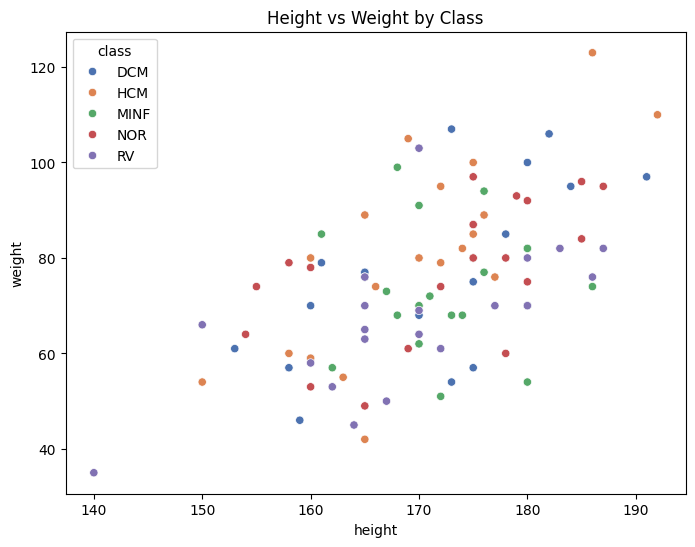

In [ ]:
# scatter plot of height vs weight colored by class
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='height', y='weight', hue='class', palette='deep')
plt.title('Height vs Weight by Class')
plt.show()

## **2. Training and Validation Set Creation**

In order to be able to get a good fitting of the model and a reliable metric for the performance it is necessary to separate the dataset into three different sets:

- **Training set (60–80%)**: Used to fit the model and learn patterns from the data.

- **Validation set (10–20%)**: Used to tune hyperparameters and monitor model performance during training.

- **Test set (10–20%)**: Used to evaluate the final model’s performance on unseen data.

This section aims to devide the dataset into this groups in order to have it prepared to build our models.

First of all it is important to separete our target variable class from the rest of the features.

In [ ]:
import pandas as pd
X = df.drop(columns=['class'])  # Features
y = df['class']  # Target

Then, we will do a simple train-test split in order to generate a train set and a test set. We will make the test set to include 20% of our data and beeing stratified, meaning that the proportion of each target class will be preserved.

In [ ]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

However, we have two different sets now, but we need to create an additional validation set in order to use it to tune the hyperparameters of our model. For that we will use different thecniques to do that.

First of all we will do a **simple splitting** (as done with the test set), where 20% of the data generated before will go to the validation set and the rest will be left to training set. It is important to remark that the splitting is stratifyed as well in this case.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

Additionally, we will make a stratified **K-Fold cross-validation** strategy with 5 splits (so that a 20% of the data is used as validation each time). This means that the dataset will be divided into 5 folds preserving the class distribution and the model will be trained and validated 5 times, each time using a different fold for validation and the remaining ones for training.

In [ ]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Finally, we will use the **leave one out** method wich is an other cross-validation approach that in this case will use just 1 sample as validation and rest of the samples will be left as training set. The model will be validated as many times as samples are in the dataset.

In [ ]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

## **3. Baseline Models**

## **4. Feature Engeneering and model Enhancement**

## **5. Results Analysis**